In [1]:
!pip install gensim

# Setup and Initial Exploration

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from gensim.models import Word2Vec
import gensim.downloader as api

Matplotlib is building the font cache; this may take a moment.


# Load the dataset

In [4]:
df = pd.read_csv("NikeProductDescriptions.csv")

In [5]:
print(df.shape)
print(df.info())
print(df.describe())

(400, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Title                400 non-null    object
 1   Subtitle             400 non-null    object
 2   Product Description  400 non-null    object
dtypes: object(3)
memory usage: 9.5+ KB
None
                  Title       Subtitle  \
count               400            400   
unique              254            228   
top     Nike Sportswear  Women's Shoes   
freq                 41             34   

                                      Product Description  
count                                                 400  
unique                                                400  
top     It doesn't get more legendary than this. Desig...  
freq                                                    1  


# Text Processing

In [6]:
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\azizb\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


# Cleaning text - removing special characters

In [9]:
stop_words = set(stopwords.words('english'))
def clean_text(text):
    text = re.sub(r"[^a-zA-Z ]", "", text)  # Remove special characters
    words = text.lower().split()
    words = [word for word in words if word not in stop_words]
    return " ".join(words)

df['Cleaned_Description'] = df['Product Description'].apply(lambda x: clean_text(str(x)))

# Filtering Subtitles

In [22]:
subtitles_to_keep = [
    "Men's Shoes", "Men's T-Shirt", "Women's Shoes", 
    "Skate Shoes", "Older Kids' T-Shirt"
]

df_filtered = df[df['Subtitle'].isin(subtitles_to_keep) |
                 df['Subtitle'].str.contains('Shorts', case=False, na=False)].copy()
df_filtered.loc[df_filtered['Subtitle'].str.contains('Shorts', case=False, na=False), 'Subtitle'] = 'Shorts'

print("Filtered Data Subtitles Distribution:")
print(df_filtered['Subtitle'].value_counts())

Filtered Data Subtitles Distribution:
Shorts                 45
Women's Shoes          34
Men's Shoes            31
Skate Shoes            22
Men's T-Shirt          14
Older Kids' T-Shirt     9
Name: Subtitle, dtype: int64


# Word Embedding - BoW, TF-IDF, Word2Vec, GloVe

In [10]:
vectorizer_bow = CountVectorizer()
X_bow = vectorizer_bow.fit_transform(df['Cleaned_Description'])

vectorizer_tfidf = TfidfVectorizer()
X_tfidf = vectorizer_tfidf.fit_transform(df['Cleaned_Description'])

sentences = [text.split() for text in df['Cleaned_Description']]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1)
X_word2vec = np.array([np.mean([word2vec_model.wv[word] for word in words if word in word2vec_model.wv] or [np.zeros(100)], axis=0) for words in sentences])

glove_vectors = api.load("glove-wiki-gigaword-100")
X_glove = np.array([np.mean([glove_vectors[word] for word in words if word in glove_vectors] or [np.zeros(100)], axis=0) for words in sentences])

[==================================================] 100.0% 128.1/128.1MB downloaded


# PCA Visualization

In [15]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

X_bow_pca = pca.fit_transform(X_bow.toarray()) if 'X_bow' in locals() else print("BoW not found")
X_tfidf_pca = pca.fit_transform(X_tfidf.toarray()) if 'X_tfidf' in locals() else print("TF-IDF not found")
X_word2vec_pca = pca.fit_transform(X_word2vec) if 'X_word2vec' in locals() else print("Word2Vec not found")
X_glove_pca = pca.fit_transform(X_glove) if 'X_glove' in locals() else print("GloVe not found")


# Plotting Embeddings

In [16]:
print("X_bow_pca shape:", X_bow_pca.shape if 'X_bow_pca' in locals() else "Not created")
print("X_tfidf_pca shape:", X_tfidf_pca.shape if 'X_tfidf_pca' in locals() else "Not created")
print("X_word2vec_pca shape:", X_word2vec_pca.shape if 'X_word2vec_pca' in locals() else "Not created")
print("X_glove_pca shape:", X_glove_pca.shape if 'X_glove_pca' in locals() else "Not created")

X_bow_pca shape: (400, 2)
X_tfidf_pca shape: (400, 2)
X_word2vec_pca shape: (400, 2)
X_glove_pca shape: (400, 2)


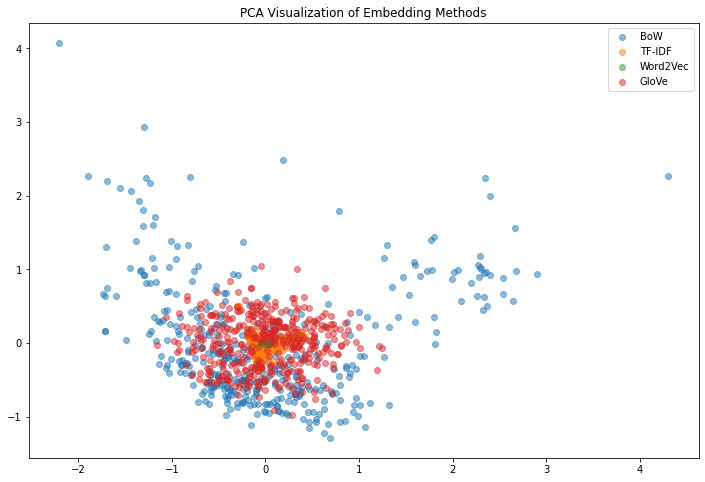

In [17]:
plt.figure(figsize=(12, 8))
plt.scatter(X_bow_pca[:, 0], X_bow_pca[:, 1], alpha=0.5, label='BoW')
plt.scatter(X_tfidf_pca[:, 0], X_tfidf_pca[:, 1], alpha=0.5, label='TF-IDF')
plt.scatter(X_word2vec_pca[:, 0], X_word2vec_pca[:, 1], alpha=0.5, label='Word2Vec')
plt.scatter(X_glove_pca[:, 0], X_glove_pca[:, 1], alpha=0.5, label='GloVe')
plt.title('PCA Visualization of Embedding Methods')
plt.legend()
plt.show()

# Comparison and Analysis

In [18]:
print("Comparing the Embeddings:\n")
print("BoW vs TF-IDF correlation:", np.corrcoef(X_bow_pca[:,0], X_tfidf_pca[:,0])[0,1])
print("BoW vs Word2Vec correlation:", np.corrcoef(X_bow_pca[:,0], X_word2vec_pca[:,0])[0,1])
print("BoW vs GloVe correlation:", np.corrcoef(X_bow_pca[:,0], X_glove_pca[:,0])[0,1])


Comparing the Embeddings:

BoW vs TF-IDF correlation: 0.9522352327685959
BoW vs Word2Vec correlation: 0.49147111552658873
BoW vs GloVe correlation: -0.09142906549182654
